## Example for decoding and encoding with auditory kernels
I hope this notebook can explain a bit better how the auditory kernels are related to the "encoding" and "decoding" of speech, and how do that! I do not have time to make the example for speech right now, so I used some handmade kernels (in this notebook they are referred to as "dictionary elements" or just "elements"). I will try to update the notebook by next week. The example shown now is kept very simple.

##### Content
- Example waveform which we are going to encode and decode. 
- Creating the dictionary (the list of kernels). Since I dont have python code for training the dictionary, we are going to cheat a bit. I will just make them by hand.
- Example of how to encode the waveform into a list of: (element of the dictionary, time at which the element occurs, amplitude with which the element occurs)
- Reconstructing the waveform based on the list

In [22]:
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
import mp_utils as mp # matching pursuit, this contains some functions which I dont want to put in the notebook directly
import librosa # common audio processing library
import IPython.display as ipd # For playing audio
 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example waveform
Below a simple waveform is given. The waveform consists of three distinct elements: a block, a part of a sawtooth, and a part of a sinusoid.

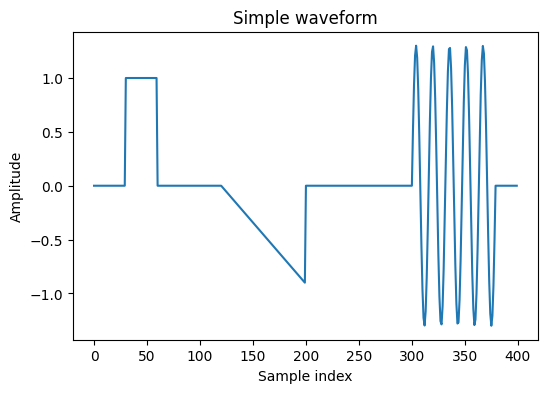

In [23]:
x = mp.get_simple_waveform()
#x += 0.05*np.random.normal(size = x.shape) # This is used at the end of the notebook

f = plt.figure()
plt.plot(x)
plt.title("Simple waveform")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
f.set_figwidth(6)
f.set_figheight(4)

Take some time to look at the waveform. If you had to come up with three elements to describe the waveform, which would you choose?

### Constructing the dictionary
Maybe you came up with different dictionary elements than me, but I choose a part of a sawtooth, a part of a sinusoid and a block. We are gonna define them below (I cheated a bit, since I used the same elements to make the waveform :D ).

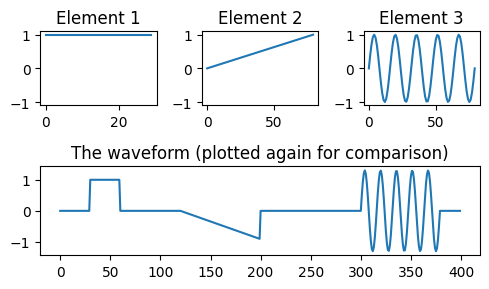

In [24]:
dictionary_element_1 = np.ones(30)
dictionary_element_2 = sig.sawtooth(0.5*np.pi * np.linspace(0,1,80) + 0.5*np.pi, 0.5)
dictionary_element_3 = np.sin(10*np.pi*np.linspace(0,1,80))

# If you want you can add a few zeros in front and at the end of the dictionary elements to make the visualisation more clear.
zero = np.zeros(0) # make the (0) a (5) or smthng to make the visualisaiton a bit clearer. 
dictionary_element_1 = np.concatenate((zero, dictionary_element_1, zero))
dictionary_element_2 = np.concatenate((zero, dictionary_element_2, zero))
dictionary_element_3 = np.concatenate((zero, dictionary_element_3, zero))

mp.plot_simple_dictionary_and_waveform(dictionary_element_1, dictionary_element_2, dictionary_element_3, x)

Now take a look at the different elements. You probably notice that their amplitude is similar, but that their durations differ a bit. Usually,it is attempted to make each element of the dictionary equally important. This is done by giving each element the same $l_2$ norm (euclidian norm). It is not needed to understand why for now. The $l_2$ norm is the square root of the sum of the squared elements. I.e.

\begin{equation}
    l_2(x) = \sqrt{\sum_n |x[n]|^2}
\end{equation}

Note that $x[n]$ is simply the $n$th element of $x$. The square brackets simply indicate that $n$ is discrete ($n=0,1,2,3,4,5,6$) etc. You can think of $n$ in a similar way as how you would think of $t$ in a function $f(t)$. 

The $l_2$ norm is implemented by `numpy.linalg.norm`. Lets see how the normalisation changes the previous plot!


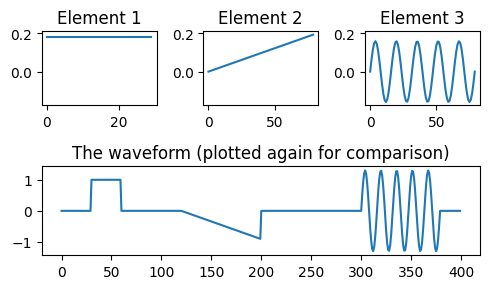

In [25]:
dictionary_element_1 = dictionary_element_1/np.linalg.norm(dictionary_element_1)
dictionary_element_2 = dictionary_element_2/np.linalg.norm(dictionary_element_2)
dictionary_element_3 = dictionary_element_3/np.linalg.norm(dictionary_element_3)

mp.plot_simple_dictionary_and_waveform(dictionary_element_1, dictionary_element_2, dictionary_element_3, x)

Inspect the waveform and compare it to the different dictionary elements. Take some time to think where you would place each element and what the amplitude of the elements should be. We are gonna figure out how to do this mathematically in a bit. 

### A first try: encoding the waveform using elements of the dictionary
We will now have a look how to mathematically figure out where to place the kernels. This is done by computing the cross-correlation between each of the dictionary elements and the waveform. The cross-correlation can be though of as a measure of: "how similar is my element to my waveform for different points in time". The correlation between the waveform $x$ and a dictionary element $D_i$ is 

\begin{equation}
 (x\star D_i)[n] = \sum_{m=-\infty}^{\infty}x[m]D_i[n+m]
\end{equation}

For those of you who now convolution, note that this is very similar! Convolution is defined as
\begin{equation}
 (x * D_i)[n] = \sum_{m=-\infty}^{\infty}x[m]D_i[n-m]
\end{equation}

The equations probably don't say a lot to you. But you can think of them as that we simply try each possible position for each dictionary element, and than compute how similar the dictionary element is to the waveform at that position. 

Below, a plot is given in which the correlation between each dictionary element and the waveform is shown. Some points of interest are highlighted.


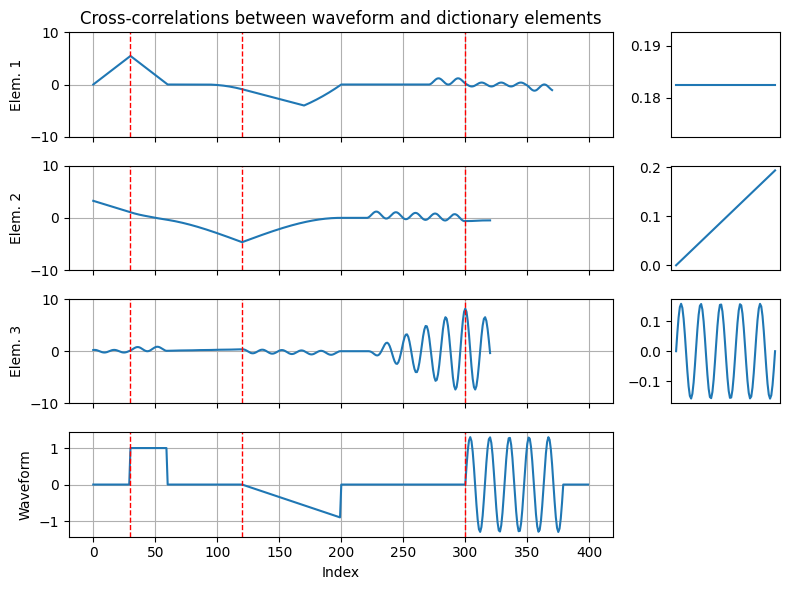

In [26]:
# Compute the correlation between the waveform and the dictionary elements
corr_1 = mp.correlation(x, dictionary_element_1)
corr_2 = mp.correlation(x, dictionary_element_2)
corr_3 = mp.correlation(x, dictionary_element_3)

# Plot the correlations and the waveform
highlighted_positions = [30, 120, 300]
mp.plot_correlations(corr_1, corr_2, corr_3, x, dictionary_element_1, dictionary_element_2, dictionary_element_3,  highlighted_positions)

Take some time to inspect the plots. Is there anything you notice?

You might notice one of the following things: 
 - The correlation plots are shorten than the waveform plot. This is because I only plot the parts where the dictionary element overlaps entirely with the waveform. Recall that, during convolution (or cross-correlation), the elements are shifted towards different places of the waveform. If the shift partially causes the element to go beyound the boundary of the waveform, the computation stops. 

 - When you start looking from the waveform, the red line appears at the 'start' of a dictionary element. If you follow this red line towards the cross-correlation plots, you can see that the maximum (absolute) value is at the intersection of the red line and the plot! We can use this to select the position and the amplitude of the dictionary elements. Let's try it out!


For each cross-correlation plot above, we are gonna compute (a) the location where the aboslute amplitude is highest and (b) compute the value of this amplitude. These values will later be used to reconstruct the waveform.

In [27]:
indxMax_1 = np.argmax(abs(corr_1))
ampMax_1 = corr_1[indxMax_1]

indxMax_2 = np.argmax(abs(corr_2))
ampMax_2 = corr_2[indxMax_2]

indxMax_3 = np.argmax(abs(corr_3))
ampMax_3 = corr_3[indxMax_3]

print("The cross-correlation between the dictionary element 1 and the waveform is highest at index: ", indxMax_1,". The amplitude is: ", ampMax_1)
print("The cross-correlation between the dictionary element 2 and the waveform is highest at index: ", indxMax_2,". The amplitude is: ", ampMax_2)
print("The cross-correlation between the dictionary element 3 and the waveform is highest at index: ", indxMax_3,". The amplitude is: ", ampMax_3)

The cross-correlation between the dictionary element 1 and the waveform is highest at index:  30 . The amplitude is:  5.477225575051662
The cross-correlation between the dictionary element 2 and the waveform is highest at index:  120 . The amplitude is:  -4.662264349086128
The cross-correlation between the dictionary element 3 and the waveform is highest at index:  300 . The amplitude is:  8.170373308484747


The list above basically represent the encoded waveform. We have a list with tuples (dictionary element, index, amplitude). This list is simply the *encoded waveform*. In the next section, we are going to decode this list to get the waveform back! Luckily, this is very straightforward. 

#### Reconstructing the waveform from the encoded waveform (decoding)
 
We will now use the information in the encoded waveform to try and reconstruct the original waveform. By inspecting the original waveform we can see that the original waveform was a lenght 400 (see plot above). We are gonna define an all-zeros vector of length 400 and simply place the dictionary elements in there! The dictionary elements we place have the indexes and amplitudes as listed above.

In [28]:
x_rec = np.zeros(400)

x_rec[indxMax_1:indxMax_1+len(dictionary_element_1)] += ampMax_1*dictionary_element_1
x_rec[indxMax_2:indxMax_2+len(dictionary_element_2)] += ampMax_2*dictionary_element_2
x_rec[indxMax_3:indxMax_3+len(dictionary_element_3)] += ampMax_3*dictionary_element_3

If everything went well we did reconstruct the waveform exactly! To verify this, we plot the original waveform, the reconstructed waveform, and the difference between the two.  

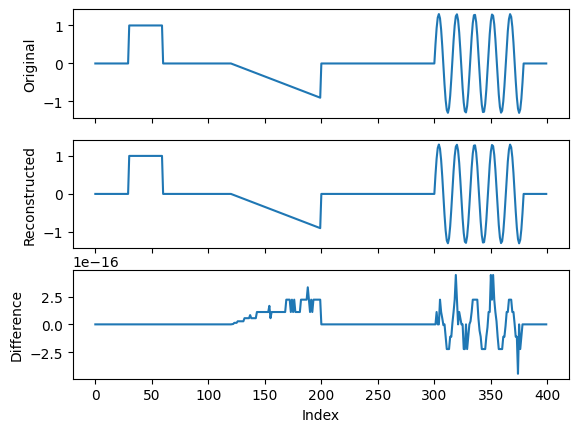

In [29]:
# Let's plot x_rec and x
ax1 = plt.subplot(311)
plt.plot(x)
plt.ylabel('Original')

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(x_rec)
plt.ylabel('Reconstructed')

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(x-x_rec)
plt.ylabel('Difference')
plt.xlabel('Index')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.show()

As you can see, the waveform is reconstructed almost exactly (up to computer accuracy). Pretty neat. 

#### Adding a little bit of noise
You can try for yourself what happens when a little bit of noise is added. At the top of the notebook (where the waveform is constructed), uncomment the line `x += 0.05*np.random.normal(size = x.shape)`. Run the notebook again, what do you observe? You might also want to use the code below, which plots both the error with respect to the noisy and to the clean waveform.

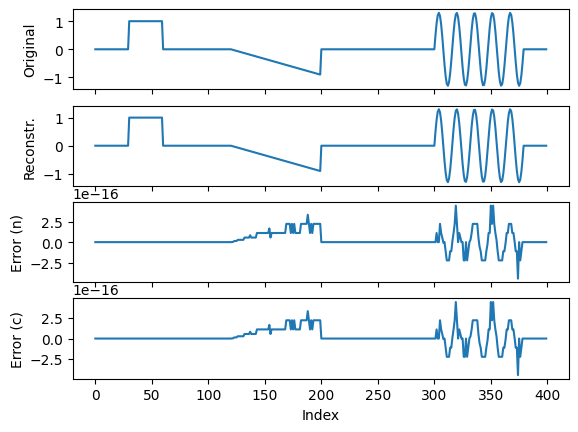

In [30]:
# Let's plot x_rec and x
ax1 = plt.subplot(411) 
plt.plot(x)
plt.ylabel('Original') # original waveofrm

ax2 = plt.subplot(412, sharex=ax1) 
plt.plot(x_rec)
plt.ylabel('Reconstr.') # reconstructed waveform

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(x-x_rec)
plt.ylabel('Error (n)') # Difference between reconstructed waveform and noisy waveform

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(mp.get_simple_waveform()-x_rec)
plt.ylabel('Error (c)') # Difference between reconstructed waveform and "clean" waveform
plt.xlabel('Index')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.show()

### A small (or big?) problem
The method we used worked very well for the example waveform, but it does not always work well...  Below, I highlight two problems with the approach we took just now and briefly explain the idea behind matching pursuit.   

##### Problems with our approach
The approach we took above has two major problems (which I can think of now):
- If one dictionary element is present in the waveform, but only has a very small amplitude: if this happens, the correlation between that dictionary element and a different part of the waveform might be higher than the correlation between the dictionary element and the corresponding part of the waveform. Thus, we would have placed that element at the wrong place! To see this, imagine that the sawtooth would have had a very large amplitude. We would probably have placed the block there as well! 
- With the current approach, we only place each dictionary element once. It is possible that some dictionary elements occur more often. Our approach does not accomodate for that.

The problems are illustrated below.

#### Example of the problems and matching pursuit
Below, two examples are given of the problems with the encoding method we used so far. After the examples I will give a quick explanation of matching pursuit.

##### Example of the problems
Below there is an example waveform which illustrates the first problem (one dictionary element which has a small amplitude in the waveform). Have a good look at the waveform. What do you expect to happen when we use the same method we used above to encode the waveform?

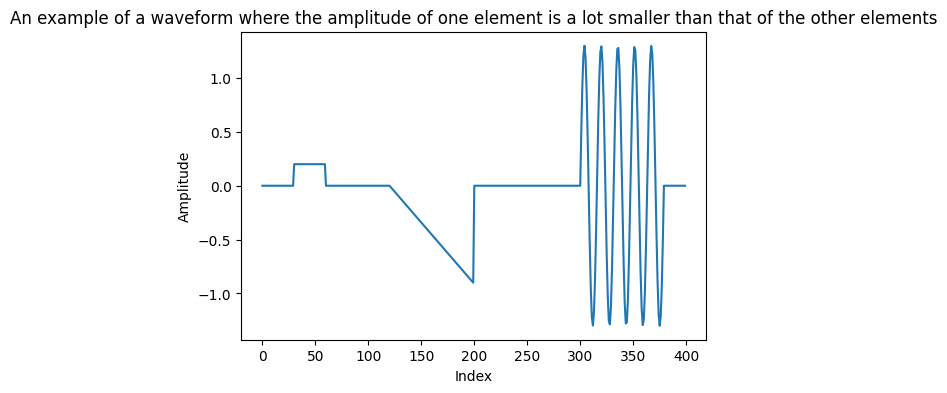

In [31]:
x = mp.get_simple_waveform(2)

f = plt.figure()
plt.plot(x)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title("An example of a waveform where the amplitude of one element is a lot smaller than that of the other elements")
f.set_figwidth(6)
f.set_figheight(4)
plt.show()

The function `mp_utils.simple_method_to_encode_and_decode_waveform` encodes the waveform based on the approach we also used earlier and returns the reconstructed waveform. Lets have a look what it looks like for this waveform. 

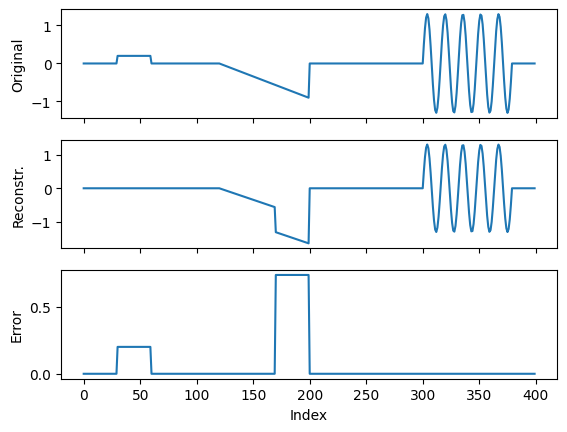

In [32]:
x_rec = mp.simple_method_to_encode_an_decode_waveform(x, dictionary_element_1, dictionary_element_2, dictionary_element_3, 400)

# Let's plot x_rec and x
ax1 = plt.subplot(311) 
plt.plot(x)
plt.ylabel('Original') # original waveofrm

ax2 = plt.subplot(312, sharex=ax1) 
plt.plot(x_rec)
plt.ylabel('Reconstr.') # reconstructed waveform

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(x-x_rec)
plt.ylabel('Error') # Difference between reconstructed waveform and "clean" waveform
plt.xlabel('Index')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.show()

Have a look at the reconstructed waveform. Does it look like you expected? As you can see, the block at the left does not get selected. Instead, the dictionary element of the block is also put on top of the ramp! Thus, we get a large error there... 

Lets now have a look at the other problem: what happens when we need to use the same dictionary element twice? A waveform where this is required is shown below. Note that we would need to use the block element twice.

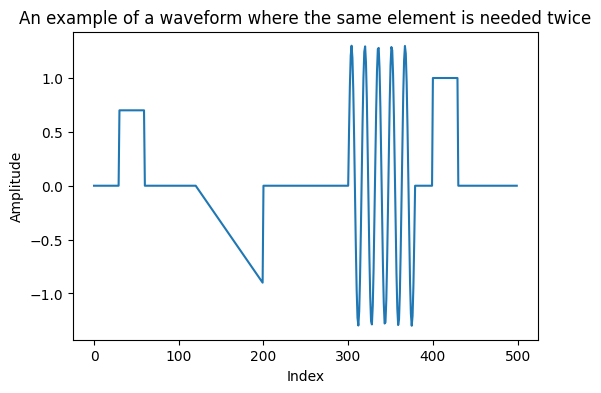

In [33]:
x = mp.get_simple_waveform(3)

f = plt.figure()
plt.plot(x)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title("An example of a waveform where the same element is needed twice")
f.set_figwidth(6)
f.set_figheight(4)
plt.show()

Take a moment to try and predict what the reconstructed waveform will look like. Do you have an idea? Lets see if your idea is correct :)

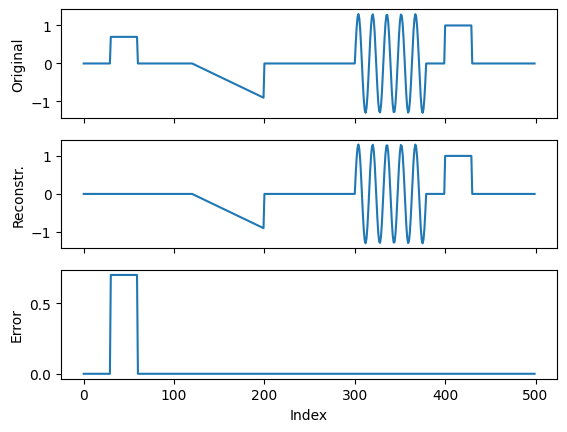

In [34]:
x_rec = mp.simple_method_to_encode_an_decode_waveform(x, dictionary_element_1, dictionary_element_2, dictionary_element_3, 500)

# Let's plot x_rec and x
ax1 = plt.subplot(311) 
plt.plot(x)
plt.ylabel('Original') # original waveofrm

ax2 = plt.subplot(312, sharex=ax1) 
plt.plot(x_rec)
plt.ylabel('Reconstr.') # reconstructed waveform

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(x-x_rec)
plt.ylabel('Error') # Difference between reconstructed waveform and "clean" waveform
plt.xlabel('Index')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.show()

As you can see, we were not able to include the leftmost block in the reconstructed waveform. We will now have a closer look at a simple algorithm, known as matching pursuit, which removes these two problems.

### Matching Pursuit
In general, the problem of encoding the waveform into the *smallest* possible number of dictionary elements is NP-hard. Thus, only approximate solutions are feasible. A common method, which works well in practice, is **matching pursuit**.

[Matching pursuit](https://doi.org/10.1109/78.258082) is a simple algorithm which was proposed in 1993 and can be used to decompose a signal into elements of the dictionary. It is not perfect (I wont go into that now), but generally works quite well. The ingredients are very similar to what we did above! So hopefully it is easy to understand. The steps are as follows:

- (1) Compute the cross-correlation between the waveform and all elements in the dictionary;
- (2) Pick the single element with the highest absolute cross-correlation;
- (3) Substract this element (with the correct amplitude and time-shift) from the waveform to get the new waveform;
- (4) Repeat until some stopping condition is met.


In the remainder of this notebook we will play around with matching pursuit. As was already mentioned, matching pursuit is an algorithm which can be used to *encode* a waveform into a list of elements of a dictionary: very similar to what we did before! 

Before trying matching pursuit, we will construct the dictionary in a somewhat neater way than what we did before. This makes it easier to use the dictionary in the functions. 

In [35]:
dictionary = mp.create_dictionary(dictionary_element_1, dictionary_element_2, dictionary_element_3)

Each entry of the dictionary is now a dictionary element of the class `Kernel`. We can access it as follows: `dictionary[1].kernel`. Apart from the kernel, we also have the gradient `dictionary[1].gradient` and the "abs_amp": `dictionary[1].abs_amp`. There is no need to know what the latter two are for now, but they are used during training (I did not make python code for training, but this keeps it consistent between my Julia code and this Python code). Let's verify the dictionary elements.

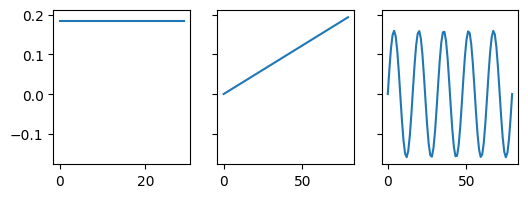

In [57]:
# Let's plot x_rec and x
f = plt.figure()
ax1 = plt.subplot(131) 
plt.plot(dictionary[0].kernel)

ax2 = plt.subplot(132, sharey=ax1) 
plt.plot(dictionary[1].kernel)

ax3 = plt.subplot(133, sharey=ax1)
plt.plot(dictionary[2].kernel)

plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
f.set_figwidth(6)
f.set_figheight(2)
plt.show()

Now that we have the dictionary ready, it's time to run the matching pursuit iterations. The function is given as `mp_utils.matching_pursuit`, and a single iteration is given by `mp_utils.matching_pursuit_iter`. This function is also copied below. Take some time to understand what it does.

In [37]:
def matching_pursuit_iter(dictionary, x_res):
    count = 0
    
    ampMax = 0
    indxMax = 0
    dicElement = 0
    
    for element in dictionary:
        x_corr = mp.correlation(x_res, element.kernel) # Compute the cross-correlation between the waveform and the dictionary element
        
        indxMax_tmp = np.argmax(abs(x_corr)) # Find the location where the max abs value is largest 
        ampMax_tmp = x_corr[indxMax_tmp] # And find the corresponding amplitude

        # If this is the kernel element with the maximum value so far: store it!
        if abs(ampMax_tmp) > abs(ampMax):
            ampMax = ampMax_tmp
            indxMax = indxMax_tmp
            dicElement = count

        count += 1
    
    #Substract the kernel from the residual
    x_res[indxMax:indxMax+len(dictionary[dicElement].kernel)] -= ampMax*dictionary[dicElement].kernel
    return x_res, ampMax, indxMax, dicElement

Hopefully you have a broad idea of how matching pursuit selects the kernel elements from the dictionary. We are gonna try it out on one of the problematic waveforms we saw earlier. It is plotted below. 

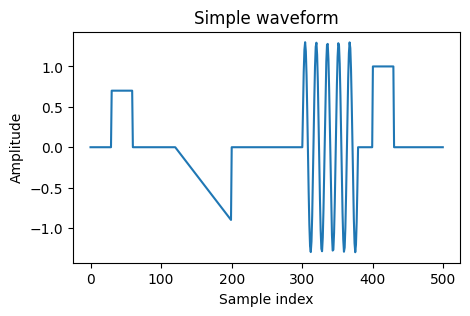

In [38]:
x = mp.get_simple_waveform(3)

f = plt.figure()
plt.plot(x)
plt.title("Simple waveform")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
f.set_figwidth(5)
f.set_figheight(3)

How many iterations of matching pursuit do you think we need to encode the waveform entirely?

We are going to apply the iterations now. The iterations are initialised with `x_res = x`. Consequently, the residual (the part of the waveform that has not been encoded yet) is the full waveform. Each iteration will update the residual by substracting the selected dictionary element, until some stopping condition is met. We will discuss the stopping condition later. For now, we are simply gonna do four iterations, since that was my answer to the previous question :)

In [39]:
x_res_0 = x
x_res_1, ampMax_1, indxMax_1, dicElement_1 = matching_pursuit_iter(dictionary, x_res_0.copy()) 
x_res_2, ampMax_2, indxMax_2, dicElement_2 = matching_pursuit_iter(dictionary, x_res_1.copy()) 
x_res_3, ampMax_3, indxMax_3, dicElement_3 = matching_pursuit_iter(dictionary, x_res_2.copy()) 
x_res_4, ampMax_4, indxMax_4, dicElement_4 = matching_pursuit_iter(dictionary, x_res_3.copy()) 

Below, the residual waveform `x_res` (i.e. the part that has not yet been encoded) is plotted alongside the selected dictionary element for each of the iterations.

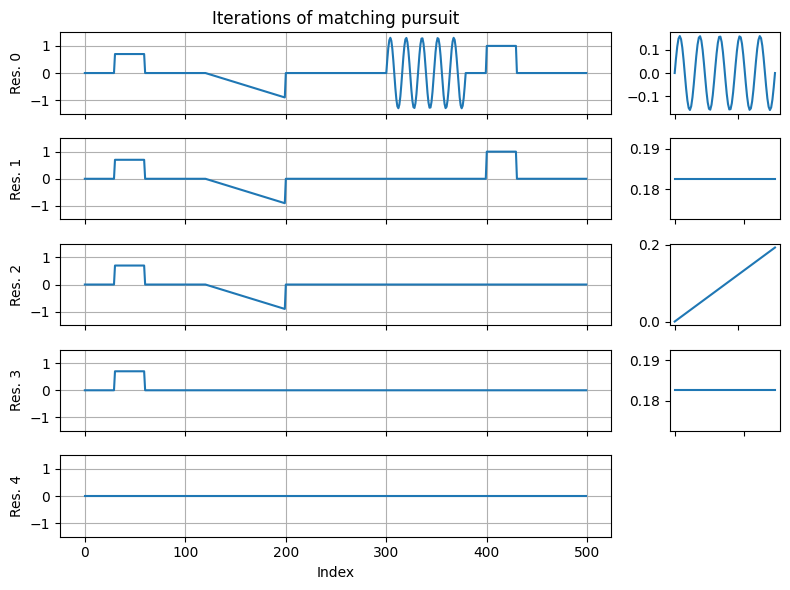

In [40]:
mp.plot_mp_iters(x_res_0, x_res_1, x_res_2, x_res_3, x_res_4, dicElement_1, dicElement_2, dicElement_3, dicElement_4, dictionary)

Of course, it is not very convenient to manually do the iterations. Instead, we can use the function `mp_utils.matching_pursuit`. This function keeps doing iterations until some stopping condition is met. I implemented two stopping conditions: `iterations` and `amplitude`. As the name implies, the first keeps going until a fixed number of iterations are reached (or the $l_2$ norm of the residue is near-zero). The second (`amplitude`) keeps the iterations going until there is a dictionary element selected with an absolute amplitude of less than some user-specified amplitude. Of course, you can add more types of stopping conditions as you see fit. For example, you could consider the signal-to-residue ratio (similar to the signal-to-noise ratio). It should be noted that the iterations also stop when the residual has an $l_2$ norm of less than $10^{-8}$ (this value is somewhat arbitrarily chosen).  

We will now have a look at the `mp_utils.matching_pursuit` function with the two different stopping conditions. The following parameters are returned: `encoded_waveform` and `residue`. The `residue` is the part of the waveform that has not yet been encoded at the time the stopping condition was met. The `encoded_waveform` is a list of tuples with `(dictionary_element, amplitude, index)`.  

In [41]:
x = mp.get_simple_waveform(3) # This is the waveform with the two blocks
x_enc_its, x_res_its = mp.matching_pursuit(dictionary, x, "iterations", 4) # encode based on fix number of iterations
x_enc_amp, x_res_amp = mp.matching_pursuit(dictionary, x, "amplitude", 0.1) # encode with amplitude as stopping condition

Now let's reconstruct the waveform from the encoded waveform and see if everything went well :). This is done using `mp_utils.reconstruct(dictionary, encoded_waveform, output_length)`, where `output_length` is the length of the reconstructed waveform. Alternatively, one could estimate `output_length` based on the length of the dictionary elements and the time indices. I was a bit lazy so I did not implement that.

In [42]:
x_dec_its = mp.reconstruct(dictionary, x_enc_its, 500)
x_dec_amp = mp.reconstruct(dictionary, x_enc_amp, 500)

Let's verify that all went well by computing the difference between the reconstructed waveform `x_dec_its` and the original waveform `x`, and similar for `x_dec_amp`.

In [43]:
print("Error between original waveform and reconstructed waveform (iterations): ", np.linalg.norm(x_dec_its-x))
print("Error between original waveform and reconstructed waveform (amplitude): ", np.linalg.norm(x_dec_amp-x))

Error between original waveform and reconstructed waveform (iterations):  2.115877004590068e-15
Error between original waveform and reconstructed waveform (amplitude):  2.115877004590068e-15


### Encoding a speech waveform
I hope the ideas behind encoding, decoding, and matching pursuit are clear now. We will finalise this notebook by seeing if we can encode a speech waveform. 

##### Gammatone filterbank
We first use a [gammatone filterbank](https://en.wikipedia.org/wiki/Gammatone_filter). A filterbank is just a collection of filters. Gammatone filters are used as a linear model of cochlear signal processing and were originally derived based on impulse responses measured in the ears of cats. A dictionary of gammatone filters is created and plotted below. Note that the filter in the top-left is 813 samples, while the one on the bottom-right is only 42 samples: about 20 times shorter!

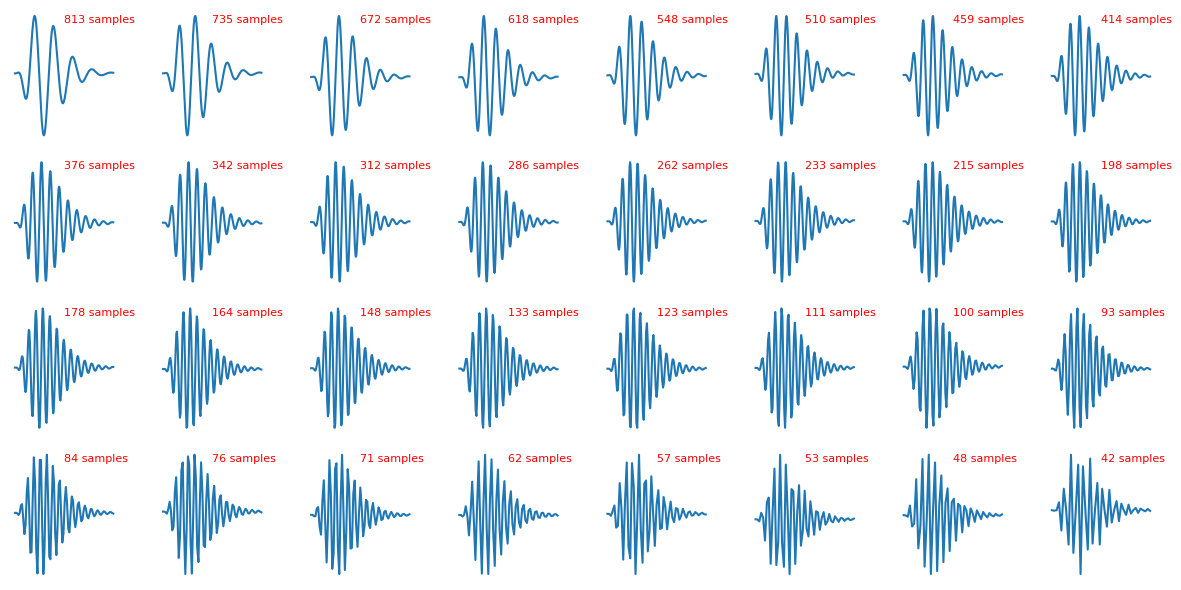

In [44]:
fs = 16000
gammatone_dictionary = mp.create_gammatone_dictionary(num_filters = 32, fs = fs, f_min = 100, f_max = 6000)
mp.plot_dictionary_elements(gammatone_dictionary)

Now load a short audiofile. We used `fs=16000` Hz to generate the filterbank. Parameter `fs` is the sampling frequency (number of samples taken per second), so we should use an audiofile which matches this.

In [45]:
y, fs_audio = librosa.load("SA1.WAV", sr=None)
if fs_audio != fs:
    print('Invalid sampling rate')
y = y/np.max(np.abs(y)) 
ipd.Audio(y, rate=fs)

We are now going to normalise the waveform to have an amplitude of 1, and subsequently encode the waveform using the gammatone dictionary. This might take a while. 

In [46]:
print("Running matching pursuit. This might take a while...")
y_enc, y_res = mp.matching_pursuit(gammatone_dictionary, y, "amplitude", 0.1) # encode with amplitude as stopping condition
print("Running matching pursuit finished.")

Running matching pursuit. This might take a while...
Running matching pursuit finished.


Now reconstruct the encoded waveform and have a listen! Compare it with the original audio given earlier. What do you think?

In [47]:
y_rec = mp.reconstruct(gammatone_dictionary, y_enc, len(y))
ipd.Audio(y_rec, rate=fs)

Your conclusion might be that the audio does not sound great, but the speech is more or less intelligible. Lets have a look at the number of selected elements and compare it to the length of the audio.

In [48]:
print("The original audio consists of ", len(y), 'samples')
print("The original audio consists of ", len(y_enc), 'samples (but each sample has three elements)')

The original audio consists of  46797 samples
The original audio consists of  1719 samples (but each sample has three elements)


Where the original audio signal consisted of almost 45000 samples, it was encoded into $1719\times 3\approx 5160$ elements now. 

To finalise the discussion about the gammatone filters, we will have a quick listen to the residual element. 

In [49]:
ipd.Audio(y_res, rate=fs)

##### Learned kernels
We will now load a dictionary consisting of learned kernels. The kernels were initialised as random noise and trained on the TIMIT dataset. The kernels are stored as `.jld2` files. I put three different sets: `kernels_{4620, 10640, 15040}`. These are simply different stated during the training process. Let's load `kernels_15040.jld2`. 

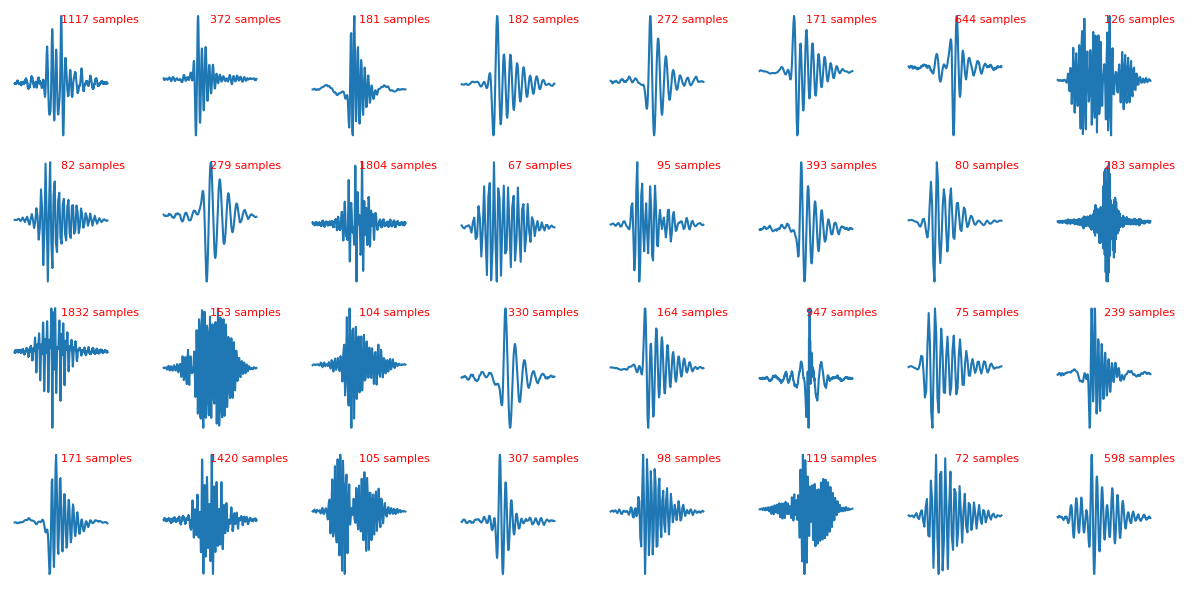

In [50]:
learned_dictionary = mp.create_dictionary_from_JLD2("kernels_15040.jld2")
mp.plot_dictionary_elements(learned_dictionary)

Compare the learned dictionary with the gammatone dictionary. What are the main differences and similarities you observe?

We are gonna encode the waveform using the learned dictionary.

In [51]:
print("Running matching pursuit. This might take a while...")
y_enc, y_res = mp.matching_pursuit(learned_dictionary, y, "amplitude", 0.1) # encode with amplitude as stopping condition
print("Running matching pursuit finished.")

Running matching pursuit. This might take a while...
Running matching pursuit finished.


Let's listen to the reconstructed waveform.

In [52]:
y_rec = mp.reconstruct(learned_dictionary, y_enc, len(y))
ipd.Audio(y_rec, rate=fs)

### A brief comparison: learned kernels vs gammatone dictionary
We will finalise this notebook with a comparison between the learned kernels and the gammatone dictionary. This is by no means a complete comparison. The results are the number of kernels used vs the signal-to-residue ratio. If $x$ is the waveform that is being encoded, $x_{\text{rec}}$ the reconstructed waveform, and $x_{\text{res}}$ the residual waveform, than the signal-to-residue ratio (SRR) is:

\begin{equation}
    \text{SRR} = 20\log_{10}\left(\frac{||x||_2}{||x_{\text{res}}||_2} \right).
\end{equation}

Alright! Let's first encode the waveform we had before using the two different dictionaries. This could take a while.


In [53]:
y_enc_ld, y_res_ld = mp.matching_pursuit(learned_dictionary, y, "amplitude", 0.01) # encode with amplitude as stopping condition
y_enc_gd, y_res_gd = mp.matching_pursuit(gammatone_dictionary, y, "amplitude", 0.01) # encode with amplitude as stopping condition

We are now gonna compute and plot the SRR.

In [54]:
_, norm_list_ld = mp.reconstruct_and_get_norm(learned_dictionary, y_enc_ld, y)
_, norm_list_gd = mp.reconstruct_and_get_norm(gammatone_dictionary, y_enc_gd, y)
SRR_ld = 20*np.log10(np.linalg.norm(y)/norm_list_ld)
SRR_gd = 20*np.log10(np.linalg.norm(y)/norm_list_gd)

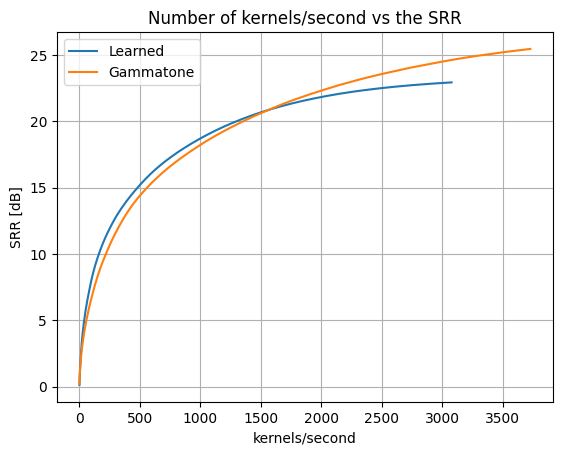

In [55]:
plt.plot(np.linspace(1, len(norm_list_ld)/len(y)*fs, len(norm_list_ld)), SRR_ld)
plt.plot(np.linspace(1, len(norm_list_gd)/len(y)*fs, len(norm_list_gd)), SRR_gd)
plt.title("Number of kernels/second vs the SRR")
plt.legend(("Learned", "Gammatone"))
plt.xlabel("kernels/second")
plt.ylabel("SRR [dB]")
plt.grid()
plt.show()

From the plot, it is observed that (for the audio example used) the learned dictionary provides a slightly higher SRR than the kernels from the gammatone dictionary, up until about 1500 kernels/second. 

### Final note
This finalises the notebook for now. I'm planning to write a bit for training as well, so it might get updated at some point.